# Convolutional Models of Multiplexing

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
# grayscale and inline plotting
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

### Visualization

In [3]:
def plot_image(image):
    nr, nc = image.shape
    extent = [-0.5, nc - 0.5, nr - 0.5, -0.5]
    plt.imshow(image, extent=extent, origin='upper', interpolation='nearest')

def visualize(t, loss, errcl, out, x0):

    loss_avg = np.divide(
        np.cumsum(loss[: t + 1]),
        range(1, t + 2)
    )

    errcl_avg = np.divide(
        np.cumsum(errcl[: t + 1]),
        range(1, t + 2)
    )

    n_last_batches = np.min([20, t])
    k = np.ones(n_last_batches * 2 + 1) / (n_last_batches + 1)
    k[:n_last_batches] = 0
    
    errcl_sm = np.convolve(np.pad(errcl, mode="edge", pad_width=n_last_batches), k, mode="valid")
    errcl_sm = errcl_sm[: len(errcl_avg)]

    loss_sm = np.convolve(np.pad(loss, mode="edge", pad_width=n_last_batches), k, mode="valid")
    loss_sm = loss_sm[: len(loss)]

    display.clear_output(wait=True)

    plt.subplot(1, 4, 1)
    plt.plot(loss, label="loss")
    plt.plot(loss_sm, label="smothed loss")
    plt.plot(loss_avg, label="avg loss")
    plt.legend()
    plt.ylim(0, np.max(loss)*1.05)
    plt.title("loss: avg - %.4f,\nsmoothed - %.4f,\ncurrent - %.4f"  % (loss_avg[t], loss_sm[t], loss[t]))

    plt.subplot(1, 4, 2)
    plt.plot(errcl, label="cl err")
    plt.plot(errcl_sm, label="smothed cl err")
    plt.plot(errcl_avg, label="avg cl err")
    plt.legend()
    plt.ylim(0, np.max(errcl)*1.05)
    plt.title("cl error: avg - %.4f,\nsmoothed - %.4f,\ncurrent - %.4f"  % (errcl_avg[t], errcl_sm[t], errcl[t]))

    plt.subplot(1, 4, 3)
    plot_image(x0)
    plt.title("input image")
    
    plt.subplot(1, 4, 4)
    plt.bar(range(len(out)), out)
    plt.title("class confidences")

    plt.subplots_adjust(wspace=1.5)
    plt.subplots_adjust(hspace=1.5)
    plt.gcf().set_size_inches(24.5, 5.5)
    display.display(plt.gcf())

### Data Preparation

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
mnist = torchvision.datasets.MNIST(root='data', train=True, download=True) # train data only
trainimages = mnist.data
trainlabels = mnist.targets

mnist = torchvision.datasets.MNIST(root='data', train=False, download=True) # test data only
testimages = mnist.data
testlabels = mnist.targets

# check training data shape
print("Training Data shape is: ", list(trainimages.size()))
print("Training Target shape is: ", list(trainlabels.size()))
print("Training Data shape is: ", list(testimages.size()))
print("Training Target shape is: ", list(testlabels.size()))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Training Data shape is:  [60000, 28, 28]
Training Target shape is:  [60000]
Training Data shape is:  [10000, 28, 28]
Training Target shape is:  [10000]


In [6]:
tempimg = np.zeros((20,20))

In [7]:
# crop images into 20 x 20
trainimages = trainimages[:, 4:-4, 4:-4]
testimages = testimages[:, 4:-4, 4:-4]

In [8]:
tempimg[5:10,0:5] = trainimages[0][0::4,0::4]

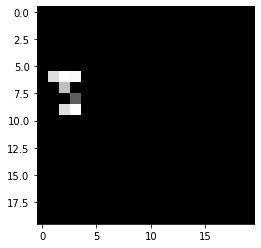

In [9]:
plt.imshow(tempimg)

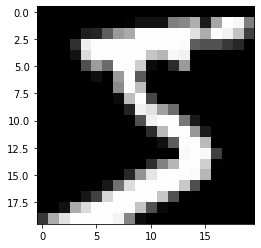

In [10]:
plt.imshow(trainimages[0])

In [11]:
%%time
def auto_cov(X):
    X = X / 255.0
    X = (X.T - X.mean(1)).T
    return X.T.dot(X)/X.shape[0]

Cov = auto_cov(trainimages.contiguous().view(trainimages.size(0), -1).numpy())

CPU times: user 827 ms, sys: 294 ms, total: 1.12 s
Wall time: 835 ms


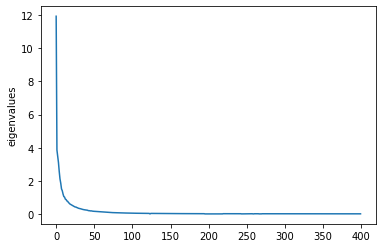

In [12]:
eigvals, eigvecs = np.linalg.eig(Cov)
plt.plot(np.arange(len(eigvals)), eigvals)
plt.ylabel("eigenvalues")
plt.show()

In [13]:
print("{:.2f}% variance explained by top 50 PCs".format(100*eigvals[:50].sum()/eigvals.sum()))
print("{:.2f}% variance explained by top 80 PCs".format(100*eigvals[:80].sum()/eigvals.sum()))

86.54% variance explained by top 50 PCs
92.08% variance explained by top 80 PCs


### Single Instance Architecture

In [14]:
class LeNet(nn.Module):

    # definition of each neural network layer
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.C1 = nn.Conv2d(1, 6, kernel_size=(3, 3))
        self.S2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C3 = nn.Conv2d(6, 16, kernel_size=(4, 4))
        self.S4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C5 = nn.Conv2d(16, 120, kernel_size=(3, 3))
        self.F6 = nn.Linear(120, 84)
        self.OL = nn.Linear(84, 10)

    # definition of the forward pass
    def forward(self, x):
        
        x = torch.tanh(self.C1(x))
        x = self.S2(x)
        x = torch.tanh(self.C3(x))
        x = self.S4(x)
        x = torch.tanh(self.C5(x))
        x = x.view(x.size(0), -1) 
        x = torch.tanh(self.F6(x))
        x = torch.tanh(self.OL(x))
        
        return x

### Training

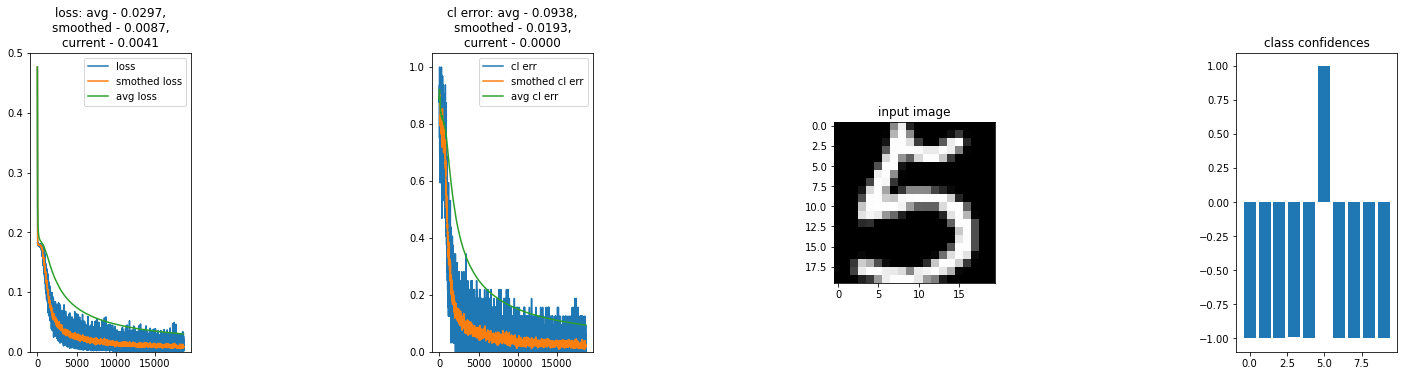

2.6040685176849365 seconds per 200 iterations


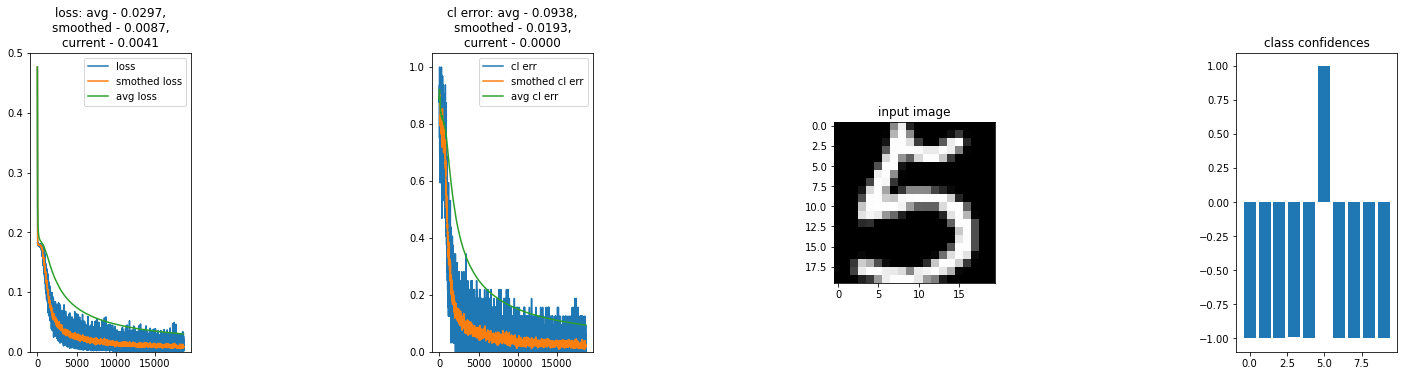

In [15]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10;                    # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size

errs = []
losses = []

cnn = LeNet().to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(cnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        
        # label 1 for the correct digit and -1 for the incorrect digits
        y = torch.ones(10, batchsize) * (-1)
        y[trainlabels_iter, torch.arange(batchsize, dtype=torch.int64)] = 1

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.

        optimizer.zero_grad()
        out = cnn(imgs.view(len(batchindices), 1, 20, 20).to(device))
        loss = torch.mean(0.5*(y.to(device) - out.t())**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        pred = torch.argmax(out, dim=1)
        err = torch.mean((pred != trainlabels_iter.to(device)).float())
        errs.append(err.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

        
        # plots
        if (t + 1) % disp_freq == 0:
            plt.gcf().clear()
            visualize(len(errs) - 1, losses, errs, out[0,:].detach().cpu(), imgs[0].detach().cpu())
            print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
            t_start = time.time()
            time.sleep(0.01)

In [16]:
%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
out = cnn(imgs.view(ntest, 1, 20, 20).to(device))
pred = torch.argmax(out, dim=1)
err = torch.mean((pred != testlabels.to(device)).float())

print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 97.61%
CPU times: user 39.5 ms, sys: 19.3 ms, total: 58.8 ms
Wall time: 108 ms


### Multiple Instance Architecture

In [17]:
from scipy.stats import ortho_group, special_ortho_group
from scipy import ndimage

class MuxLeNet(nn.Module):

    # definition of each neural network layer
    def __init__(self, K, mod='Gaussian'):
        super(MuxLeNet, self).__init__()
        
        self.K = K
        
        self.C1 = nn.Conv2d(1, 10, kernel_size=(3, 3))
        self.S2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C3 = nn.Conv2d(10, 16, kernel_size=(4, 4))
        self.S4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C5 = nn.Conv2d(16, 120, kernel_size=(3, 3))
        self.F6 = nn.Linear(120, 84)
        
        self.DCs = nn.ModuleList([nn.Linear(84, 84) for _ in range(self.K)])
        
        self.OL = nn.Linear(84, 10)
        
        self.mod = mod
        if mod == 'Gaussian':
            self.rop = [torch.randn([1,1,3,3], requires_grad=False).to(device) for _ in range(K)]
        elif mod == 'graded':
            # identity projections, fixed
            self.rop = [(g+1) * torch.ones([1,1,3,3], requires_grad=False).to(device) for g in range(K)]
        elif mod == 'identity':
            # identity projections, fixed
            self.rop = [torch.ones([1,1,3,3], requires_grad=False).to(device) for _ in range(K)]
        elif mod == 'learnable':
            self.register_parameter(name='rop', param=torch.nn.Parameter(torch.randn([K,1,1,3,3])))
        elif mod == 'SO(N)':
            self.rop = [torch.Tensor(special_ortho_group.rvs(dim=400)).to(device) for _ in range(self.K)]
        elif mod == 'learnable-W':
            self.register_parameter(name='rop', param=torch.nn.Parameter(torch.randn([K,400,400])))
        elif mod == 'nonlinear':
            self.register_parameter(name='rop', param=torch.nn.Parameter(torch.randn([K,16,1,3,3])))
            self.register_parameter(name='rop2', param=torch.nn.Parameter(torch.randn([K,1,16,3,3])))
        elif mod == 'nonlinear-expand':
#             self.expand_factor = 4
            self.expand_factor = 8
            self.register_parameter(name='rop', param=torch.nn.Parameter(torch.randn([K,16,1,3,3])))
            self.register_parameter(name='rop2', param=torch.nn.Parameter(
                                                  torch.randn([K,self.expand_factor,16,3,3])))
            self.C1 = nn.Conv2d(self.expand_factor, 10, kernel_size=(3, 3))
        elif mod == 'rotation':
            self.rop = [360 / K * i for i in range(K)]
        elif mod == 'remap':
            self.rop = [i for i in range(K)]
        
    def proj(self, imgs):
        comp_imgs = torch.zeros(imgs.shape[1], imgs.shape[2], 
                                imgs.shape[3], imgs.shape[4]).to(device)
        if self.mod == 'rotation':
            for i, r in enumerate(self.rop):
                comp_imgs += torch.from_numpy((1-2*i) * ndimage.rotate(imgs[i].cpu().numpy(), angle=r, 
                                                                       axes=(2,3), reshape=False)).to(device)
        elif self.mod == 'remap':
            for i, r in enumerate(self.rop):
                row = r % 4
                col = r // 4
                comp_imgs[:, 5*row:5*(row+1), 5*col:5*(col+1)] += imgs[i][:,::4,::4]
        elif self.mod in ['SO(N)', 'learnable-W']:
            for i, r in enumerate(self.rop):
                comp_imgs += imgs[i].view(-1, 400).mm(r).view(imgs.shape[1], -1, 20, 20)
        elif self.mod == 'nonlinear':
            for i, r in enumerate(self.rop):
                tmp_imgs = nn.functional.conv2d(imgs[i], weight=r, padding=1)
                tmp_imgs = torch.tanh(tmp_imgs)
                tmp_imgs = nn.functional.conv2d(tmp_imgs, weight=self.rop2[i], padding=1)
                comp_imgs += torch.tanh(tmp_imgs)
        elif self.mod == 'nonlinear-expand':
            comp_imgs = torch.zeros(imgs.shape[1], self.expand_factor * imgs.shape[2], 
                                imgs.shape[3], imgs.shape[4]).to(device)
            for i, r in enumerate(self.rop):
                tmp_imgs = nn.functional.conv2d(imgs[i], weight=r, padding=1)
                tmp_imgs = torch.tanh(tmp_imgs)
                tmp_imgs = nn.functional.conv2d(tmp_imgs, weight=self.rop2[i], padding=1)
                comp_imgs += torch.tanh(tmp_imgs)
        else:
            for i, r in enumerate(self.rop):
                comp_imgs += nn.functional.conv2d(imgs[i], weight=r, padding=1)
        return comp_imgs   
        
    # definition of the forward pass
    def forward(self, x):
        
        x = torch.tanh(self.C1(x))
        x = self.S2(x)
        x = torch.tanh(self.C3(x))
        x = self.S4(x)
        x = torch.tanh(self.C5(x))
        x = x.view(x.size(0), -1) 
        x = torch.tanh(self.F6(x))
        out = [torch.tanh(self.OL(torch.tanh(dc(x)))) for dc in self.DCs]
            
        return out

In [18]:
for i, (r, r2) in enumerate(zip([1,2], [3,4])):
    print(r, r2)

1 3
2 4


### Sanity Check, K = 1

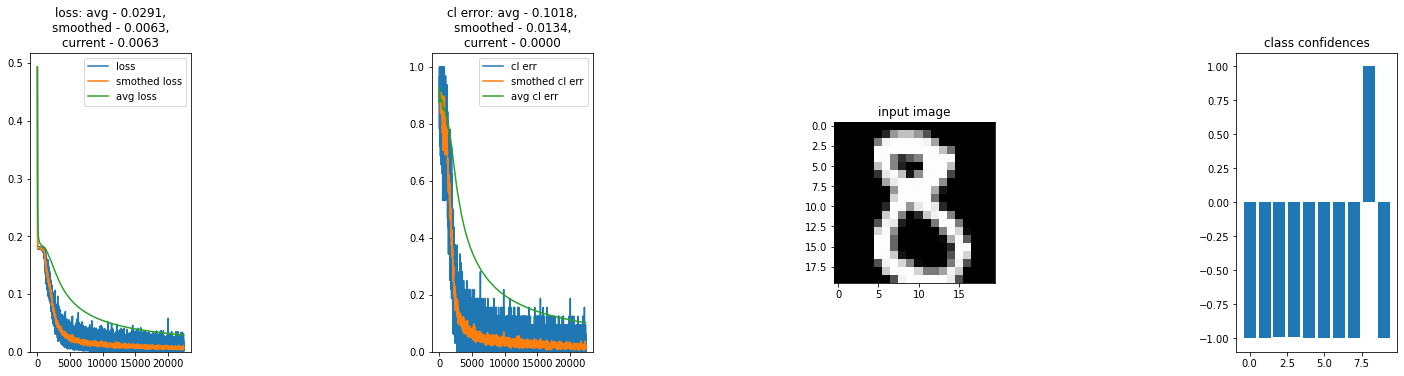

2.787976026535034 seconds per 200 iterations


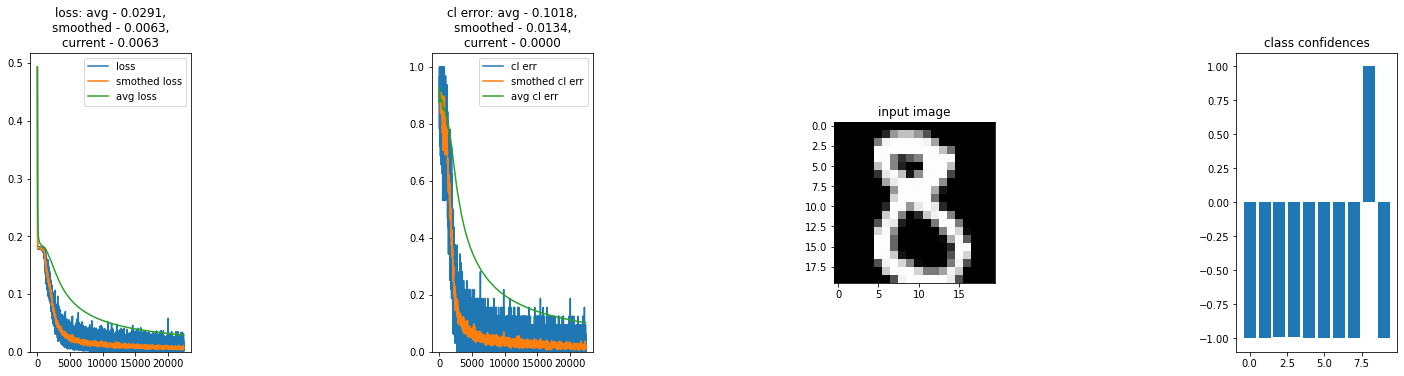

In [19]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 12                    # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 1                          # multiplex

errs = []
losses = []

muxcnn = MuxLeNet(K, 'rotation').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].to(device) - out.t())**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs.append(err.detach().cpu().numpy())
            losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs) - 1, losses, errs, out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [20]:
%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 97.95%
CPU times: user 1.11 s, sys: 19 ms, total: 1.13 s
Wall time: 1.13 s


### Sanity Check, K=2

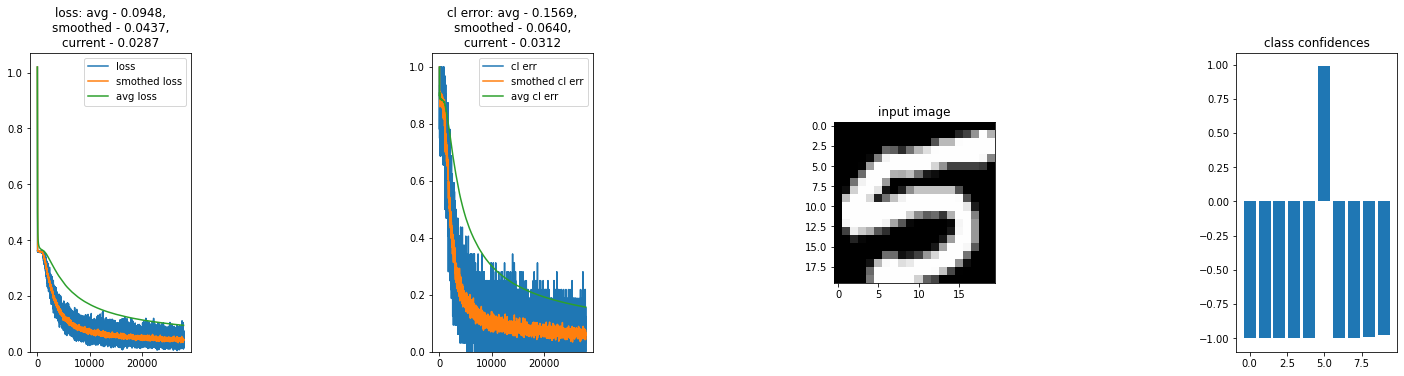

tensor(5, device='cuda:0')
0.9889812469482422 seconds per 200 iterations


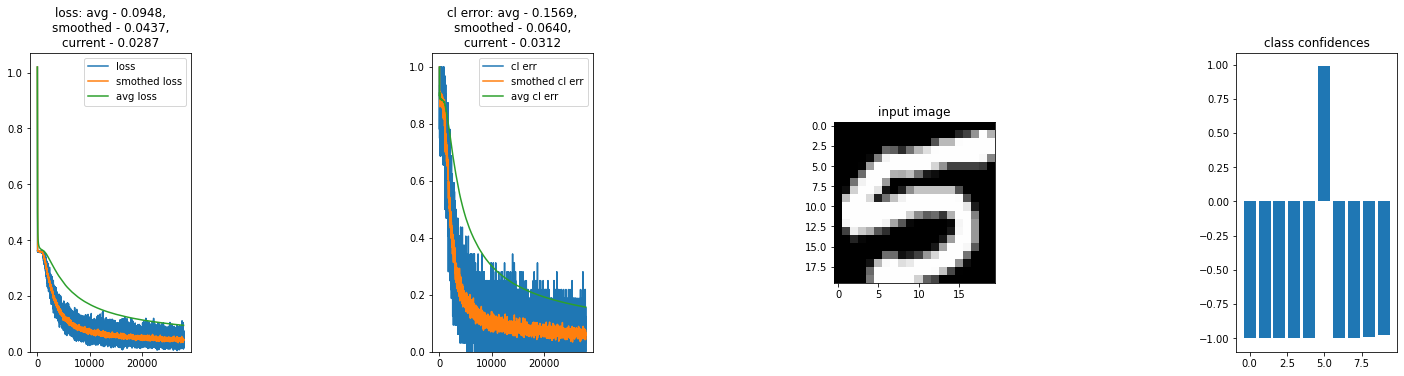

In [21]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 15;                    # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 2                         # multiplex

errs = {i:[] for i in range(K)}
losses = []

muxcnn = MuxLeNet(K, 'nonlinear').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize).to(device)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs[i].append(err.detach().cpu().numpy())
            if i == 0:
                losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs[i]) - 1, losses, errs[i], out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(torch.argmax(ys[:, i, 0]))
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [22]:

%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 91.58%
Test Acc 95.56%
CPU times: user 124 ms, sys: 11.1 ms, total: 135 ms
Wall time: 137 ms


### Number of Images vs Testing Accuracy

In [23]:
%%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 15;                     # number of epochs through training set
batchsize = 32                  # minibatch size
Ks = [1,2,4,8,16]               # multiplex

muxcnns = [MuxLeNet(K, 'nonlinear-expand').to(device) for K in Ks]

for mi, K in enumerate(Ks):
    print("training a model with {} inputs".format(K))
    optimizer = optim.SGD(muxcnns[mi].parameters(), lr=0.1)
    t_start = time.time()
    for iepoch in range(nepoch):
        for t in range(int(ntrain / batchsize)):
            batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
            trainlabels_iter = trainlabels[batchindices]
            trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)

            # label 1 for the correct digit and -1 for the incorrect digits
            ys = torch.ones(10, batchsize * K) * (-1)
            ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
            ys = ys.view(-1, K, batchsize).to(device)

            # normalize input images
            imgs = trainimages[batchindices].float() / 255.

            comp_imgs = muxcnns[mi].proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

            optimizer.zero_grad()
            outs = muxcnns[mi](comp_imgs)
            loss = 0
            for i, out in enumerate(outs):
                loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
            loss.backward()
            optimizer.step()

training a model with 1 inputs
training a model with 2 inputs
training a model with 4 inputs
training a model with 8 inputs
training a model with 16 inputs
CPU times: user 31min 38s, sys: 18.7 s, total: 31min 57s
Wall time: 31min 52s


In [24]:
%%time
ntest = testimages.shape[0]

## from learnable

mean_test_acc = []

for mi, K in enumerate(Ks):
    imgs = testimages.float() / 255.
    comp_imgs = muxcnns[mi].proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
    outs = muxcnns[mi](comp_imgs)
    
    print("----K={}----".format(K))
    errs = []
    for i, out in enumerate(outs):
        pred = torch.argmax(out, dim=1)
        err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
        errs.append(err.cpu().numpy())
        print("Test Acc {:.2f}%".format(100 * (1-err)))
    mean_test_acc.append(1-np.mean(errs))

----K=1----
Test Acc 98.58%
----K=2----
Test Acc 96.50%
Test Acc 98.26%
----K=4----
Test Acc 93.88%
Test Acc 92.84%
Test Acc 96.92%
Test Acc 95.04%
----K=8----
Test Acc 80.64%
Test Acc 79.92%
Test Acc 81.12%
Test Acc 78.24%
Test Acc 87.36%
Test Acc 87.76%
Test Acc 88.24%
Test Acc 85.92%
----K=16----
Test Acc 53.60%
Test Acc 51.04%
Test Acc 50.24%
Test Acc 53.44%
Test Acc 51.68%
Test Acc 56.00%
Test Acc 44.32%
Test Acc 53.44%
Test Acc 53.76%
Test Acc 63.52%
Test Acc 50.72%
Test Acc 50.40%
Test Acc 50.40%
Test Acc 55.04%
Test Acc 58.72%
Test Acc 56.48%
CPU times: user 684 ms, sys: 72.5 ms, total: 757 ms
Wall time: 713 ms


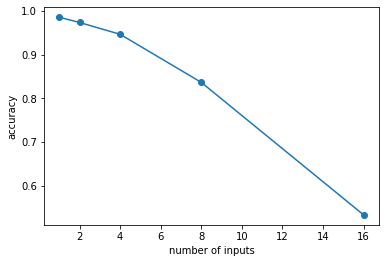

In [26]:
nl_exp8_mean_test_acc = mean_test_acc
plt.plot(Ks, nl_exp8_mean_test_acc, 'o-')
plt.xlabel('number of inputs')
plt.ylabel('accuracy')
plt.show()